In [28]:
%load_ext autoreload

%autoreload 2

from __future__ import print_function, division

import cPickle as pickle
from glob import glob
import subprocess
import sys
import string
import os
import random
import numpy as np
from os.path import join
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", dpi=144)
import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
SMALL_SIZE = 7
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

onecolumn_width = 89/25.4
twocolumn_width = 183/25.4
page_height = 247/25.4
mid1_width = 120/25.4
mid2_width = 136/25.4

golden = (1+np.sqrt(5))/2
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [3]:
name = "primary"
p = pickle.load(open(join("downhill-runs",name,"fitter_params.pickle")))
F = threebody.Fitter(**p)

In [9]:
base_orbit = F.compute_orbit(F.best_parameters)
base_p = F.last_p

In [10]:
base_p

{'acosi_i': 1.4895541513424564899,
 'acosi_o': 91.36103723804699249,
 'asini_i': 1.2175252779716744885,
 'asini_o': 74.672633134978249329,
 'dbeta': 0.0015296055665143897265,
 'delta': -1.0853003777088741092e-06,
 'delta_lan': 2.1991360118761438107e-06,
 'dgamma': -1.3379539468949432047e-05,
 'eps1_i': 0.00068826206308475963605,
 'eps1_o': 0.035185965814842112529,
 'eps2_i': -9.1395416831860648936e-05,
 'eps2_o': -0.0034630696957737554409,
 'general': True,
 'kopeikin': False,
 'matrix_mode': 0,
 'pb_i': 1.6293934166924090081,
 'pb_o': 327.25688557208299206,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13740557041242769519,
 'shapiro': True,
 'special': True,
 'tasc_i': 0.4077166413697450023,
 'tasc_o': 313.93515997689802044,
 'tol': 1e-16,
 'use_quad': False}

In [11]:
o = threebody.compute_orbit(base_p, F.mjds, keep_states=True)

In [31]:
long_orbits = {}

In [12]:
quad_orbits = {}

In [45]:
for tol in [1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17, 1e-18]:
    if tol in long_orbits:
        continue
    p = base_p.copy()
    p['tol'] = tol
    p['use_quad'] = False
    print(time.asctime(), tol)
    o = threebody.compute_orbit(p, F.mjds, keep_states=True)
    print(time.asctime(), "Done")
    long_orbits[tol] = o

Thu Dec  7 08:41:55 2017 1e-11
Thu Dec  7 08:42:11 2017 Done
Thu Dec  7 08:42:11 2017 1e-13
Thu Dec  7 08:42:34 2017 Done
Thu Dec  7 08:42:34 2017 1e-15
Thu Dec  7 08:43:07 2017 Done
Thu Dec  7 08:43:07 2017 1e-17
Thu Dec  7 08:44:40 2017 Done


In [20]:
for tol in [1e-14, 1e-16, 1e-18, 1e-20]:
    if tol in quad_orbits:
        continue
    p = base_p.copy()
    p['tol'] = tol
    p['use_quad'] = True
    print(time.asctime(), tol)
    o = threebody.compute_orbit(p, F.mjds, keep_states=True)
    print(time.asctime(), "Done")
    quad_orbits[tol] = o

In [37]:
kminl = min(*long_orbits.keys())
ol = long_orbits[kminl]
t_psrl = ol['t_psr']

kmin = min(*quad_orbits.keys())
o = quad_orbits[kmin]
t_psr = o['t_psr']


1e-17 0.0117384504348
1e-16 0.0980434969185
1e-15 0.865513971542
1e-14 11.3676623411
1e-13 164.52973215
1e-12 2366.04135703
1e-11 34151.8661267
1e-10 395221.22407


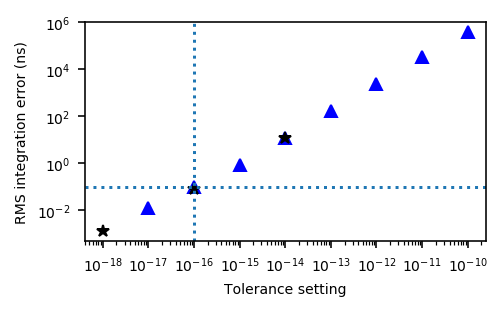

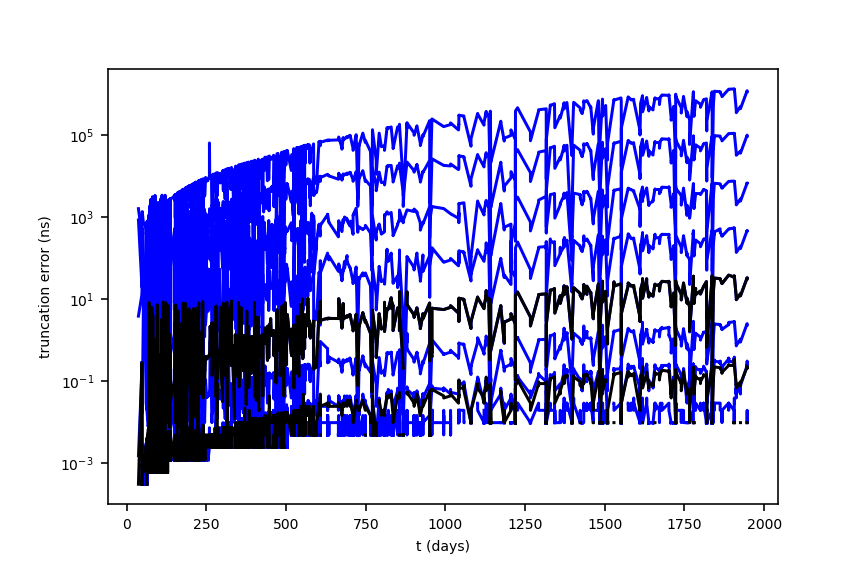

In [63]:
to_ns = 86400*1e9 # t_psr is in days
for k,o in sorted(long_orbits.items()):
    if k==kminl:
        continue
    plt.figure(1)
    v = to_ns*np.sqrt(np.mean((t_psrl-o['t_psr'])**2))
    if k==base_p["tol"]:
        used_v = v
    print(k,v)
    plt.loglog([k],[v],"^", color='b', label="80 bit")
    plt.figure(2)
    plt.semilogy(t_psr, to_ns*np.abs(t_psrl-o['t_psr']), color='b')
for k,o in quad_orbits.items():
    if k==kmin:
        continue
    plt.figure(1)
    plt.loglog([k],[to_ns*np.sqrt(np.mean((t_psr-o['t_psr'])**2))],"*", color='k', label="128 bit")
    plt.figure(2)
    plt.semilogy(t_psr, to_ns*np.abs(t_psr-o['t_psr']), color='k')
plt.figure(1)
plt.axvline(base_p["tol"], linestyle=":")
plt.axhline(used_v, linestyle=":")
plt.xlabel("Tolerance setting")
plt.ylabel("RMS integration error (ns)")
plt.gcf().set_size_inches(onecolumn_width,onecolumn_width/golden)
plt.tight_layout()
plt.savefig("tolerance.pdf")
plt.figure(2)
plt.xlabel("t (days)")
plt.ylabel("truncation error (ns)")

In [33]:
o

{'initial_values': array([  1.13350308e+02,   2.15553549e+01,   1.76181042e+01,
          6.75799047e+00,   1.69183171e+00,   1.38279321e+00,
          1.43599079e+00,   1.13348091e+02,   3.38939613e+01,
          2.77033805e+01,  -5.46088454e+01,   1.68956154e+00,
          1.38093763e+00,   1.97313134e-01,  -4.51944662e+02,
         -9.18878101e+01,  -7.51039957e+01,   2.61358197e+00,
         -6.74450899e+00,  -5.51252297e+00,   4.09641005e-01,
          0.00000000e+00]),
 'n_evaluations': 9151847,
 'parameter_dict': {'acosi_i': 1.4895541513424564899,
  'acosi_o': 91.36103723804699249,
  'asini_i': 1.2175252779716744885,
  'asini_o': 74.672633134978249329,
  'dbeta': 0.0015296055665143897265,
  'delta': -1.0853003777088741092e-06,
  'delta_lan': 2.1991360118761438107e-06,
  'dgamma': -1.3379539468949432047e-05,
  'eps1_i': 0.00068826206308475963605,
  'eps1_o': 0.035185965814842112529,
  'eps2_i': -9.1395416831860648936e-05,
  'eps2_o': -0.0034630696957737554409,
  'general': True,


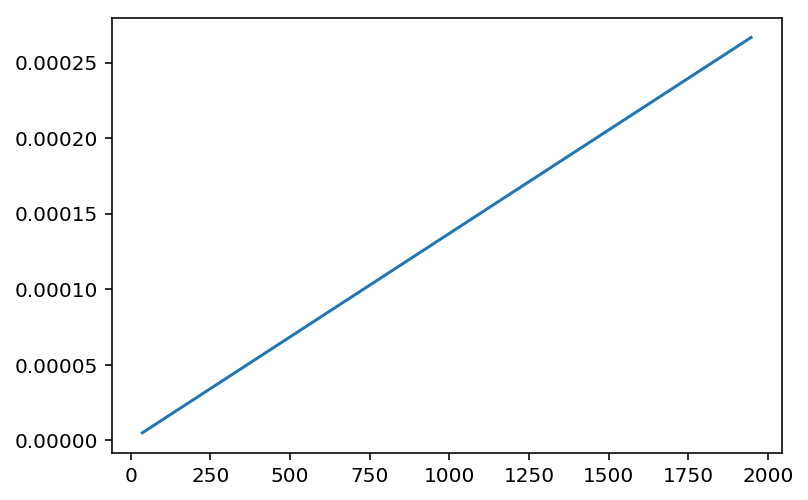

In [40]:
plt.plot(t_psrl, t_psr-t_psrl)

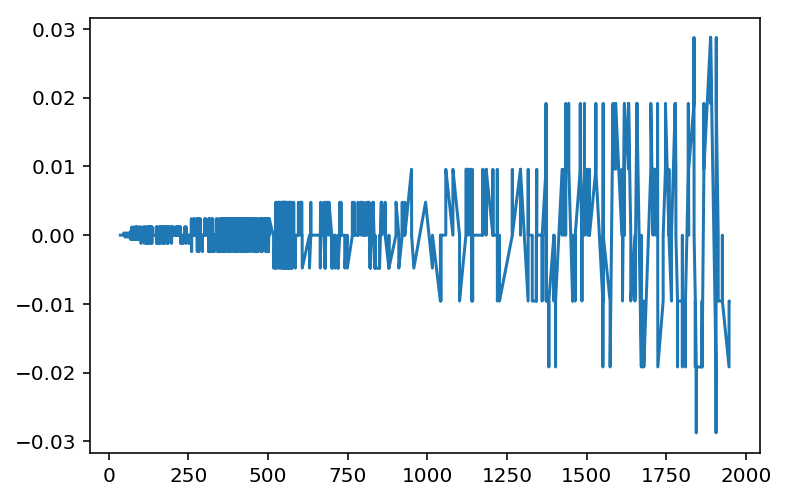

In [53]:
oq = quad_orbits[kmin]
ol = long_orbits[kminl]

n = "t_d"
plt.plot(t_psrl, to_ns*(oq[n]-ol[n]))

In [55]:
import scipy.stats

scipy.stats.norm

In [60]:
xs = np.arange(10)
ys = np.arange(10)+1

n = scipy.stats.norm(xs,ys)

n.cdf(np.arange(10))

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5])